## Portfolio Optimization Using Mean-Variance Analysis – 2021-10-29
### 1. Load Data & Basic Analysis
1. Load data set of *monthly* asset returns.
2. Drop the `Date` and `Wilshire_5000` columns.
    * Dates will not be used.
    * The Wilshire_5000 asset is the benchmark asset; it will not be used.
3. Get the correlation matrix of the 10 assets.
4. Plot a basic line plot of asset returns.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
from timeit import default_timer as timer

In [2]:
df_ret = pd.read_csv('monthly_returns.csv')
df_ret.drop(['Date', 'Wilshire_5000'], axis=1, inplace=True)
df_ret.head()

,T_Bill,Russell_1000,Russell_2000_Value,Russell_2000_Growth,Barclays_US_Bonds,Barclays_IG_Bonds,Barclays_HY_Bonds,GSCI_Precious_Metals,EAFE_Intl_Index,FTSE_REIT_Index
0,0.4343,-4.09407,-2.61501,-0.93064,-0.33529,-0.35237,-0.43146,-0.78101,-6.33645,0.33968
1,0.4295,-0.26747,6.11212,23.26645,0.82775,0.92724,0.19381,2.63335,2.71088,-1.30509
2,0.4377,9.11200,0.46884,-10.51160,1.14142,0.85203,-2.10223,-3.55476,3.89570,3.24183
3,0.4595,-3.33361,0.59191,-10.09654,-0.04015,-0.87839,0.16032,-1.44397,-5.24430,6.58641
4,0.4782,-2.58635,-1.52602,-8.75643,0.26705,-0.37239,-1.02544,0.41937,-2.42273,1.04669


In [3]:
df_ret.corr()

,T_Bill,Russell_1000,Russell_2000_Value,Russell_2000_Growth,Barclays_US_Bonds,Barclays_IG_Bonds,Barclays_HY_Bonds,GSCI_Precious_Metals,EAFE_Intl_Index,FTSE_REIT_Index
T_Bill,1.000000,-0.115686,-0.021348,-0.110846,0.215160,-0.016381,-0.116547,0.031180,-0.075149,-0.008829
Russell_1000,-0.115686,1.000000,0.822160,0.828045,-0.335435,0.206236,0.655880,0.077423,0.869483,0.622982
Russell_2000_Value,-0.021348,0.822160,1.000000,0.848673,-0.313946,0.164057,0.622999,0.064176,0.735992,0.735298
Russell_2000_Growth,-0.110846,0.828045,0.848673,1.000000,-0.358475,0.143271,0.617292,0.110943,0.739519,0.535980
Barclays_US_Bonds,0.215160,-0.335435,-0.313946,-0.358475,1.000000,0.558696,-0.180436,0.261529,-0.238626,-0.036908
Barclays_IG_Bonds,-0.016381,0.206236,0.164057,0.143271,0.558696,1.000000,0.543452,0.299389,0.334767,0.385730
Barclays_HY_Bonds,-0.116547,0.655880,0.622999,0.617292,-0.180436,0.543452,1.000000,0.161738,0.682558,0.617870
GSCI_Precious_Metals,0.031180,0.077423,0.064176,0.110943,0.261529,0.299389,0.161738,1.000000,0.208479,0.158772
EAFE_Intl_Index,-0.075149,0.869483,0.735992,0.739519,-0.238626,0.334767,0.682558,0.208479,1.000000,0.600615
FTSE_REIT_Index,-0.008829,0.622982,0.735298,0.535980,-0.036908,0.385730,0.617870,0.158772,0.600615,1.000000


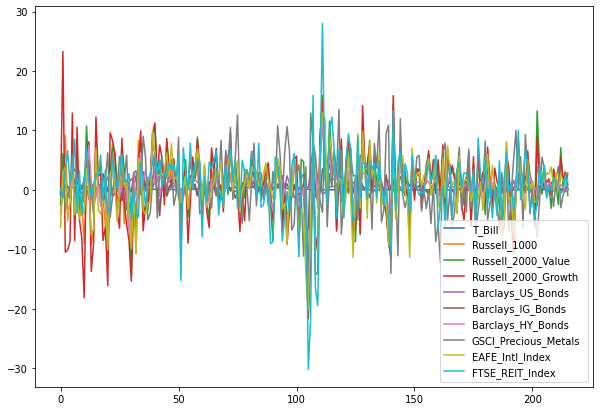

In [4]:
df_ret.plot(figsize=(10, 7))
plt.show();

### 2. Basic Functions
* `simulate`: Simulates *n* portfolios of random asset allocations. Does not allow shorts.

Given an array of asset weights and the data frame of returns (*not* price):
* `get_portfolio_stdev`: Returns the portfolio standard deviation (risk).
* `get_portfolio_return`: Returns the portfolio return.
* `get_portfolio_sharpe`: Returns the Sharpe ratio.
    * If `slsqp=True`, return negative Sharpe ratio (for minimization).

Note: All functions work on monthly returns, hence the `* 12` on some calculations.

In [5]:
def simulate(df, n_iter):
    n_tickers = len(df.columns)
    portfolio_returns = []
    portfolio_stdevs = []
    for i in range(n_iter):
        weights = np.random.dirichlet(np.full(n_tickers, 1. / n_tickers))
        portfolio_returns.append(np.sum(df.mean() * 12 * weights)) # x12 to annualize monthly return
        portfolio_stdevs.append(np.sqrt(np.dot(weights, np.dot(df.cov() * 12, weights))))
    return {'portfolio_returns': portfolio_returns, 'portfolio_stdevs': portfolio_stdevs}


def get_portfolio_stdev(weights, df):
    weights = np.array(weights)
    portfolio_stdev = np.sqrt(np.dot(weights, np.dot(df.cov() * 12, weights)))
    return portfolio_stdev


def get_portfolio_return(weights, df):
    weights = np.array(weights)
    portfolio_return = np.sum(df.mean() * 12 * weights)
    return portfolio_return


def get_portfolio_sharpe(weights, df, slsqp=False):
    portfolio_stdev = get_portfolio_stdev(weights, df)
    portfolio_return = get_portfolio_return(weights, df)
    sharpe = portfolio_return / portfolio_stdev
    if slsqp is False:
        return sharpe
    elif slsqp is True:
        return -sharpe

### 3. Optimization Functions
<ins>Decision Variables</ins>
* Weights of each asset in the portfolio.

<ins>Objective</ins>
* The function `optimize` finds asset weights that minimize the standard deviation (risk) of the portfolio.
* The function `optimize_sharpe` finds asset weights that maximize the Sharpe ratio of the portfolio (minimize negative Sharpe).

<ins>Constraints</ins>
* Constraint (1): Sum of all asset weights must equal 1.
* Constraint (2): Optimized portfolio return must equal the target return. Not used in the function `optimize_sharpe`.
* Constraint (3):
    * If shorts against T-Bills (and only T-Bills) are not allowed, then asset weights must be non-negative.
        * Also, restrict investment to all assets *except* T-Bills.
        * In addition, the variables are bounded between (0, 1).
    * If shorts against T-Bills (and only T-Bills) are allowed, then only assets that are not T-Bills must have non-negative weights.
        * In addition, the variables are unbounded.

In [6]:
# Function to optimize weights to minimize standard deviation, subject to meeting target_return
def optimize(df, target_return, allow_short_tbill=False):
    n_tickers = len(df.columns)
    initial_guess = np.full(n_tickers, 1. / n_tickers)
    
    # Constraint (1), Constraint (2)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: target_return - get_portfolio_return(weights=x, df=df)}]
    
    # Constraint (3), Bounds
    if allow_short_tbill is False:
        constraints = [{'type': 'ineq', 'fun': lambda x: x},
                       {'type': 'eq', 'fun': lambda x: x[0]}] + constraints
        bounds = ((0, 1),) * n_tickers
    elif allow_short_tbill is True:
        constraints = [{'type': 'ineq', 'fun': lambda x: x[1:10]}] + constraints
        bounds = ((None, None),) * n_tickers
    
    solution = minimize(fun=get_portfolio_stdev, x0=initial_guess, args=(df),
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return solution['x']


# Function to optimize weights to maximize Sharpe (minimize negative Sharpe)
def optimize_sharpe(df, allow_short_tbill=False):
    n_tickers = len(df.columns)
    initial_guess = np.full(n_tickers, 1. / n_tickers)
    
    # Constraint (1)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # Constraint (3), Bounds
    if allow_short_tbill is False:
        constraints = [{'type': 'ineq', 'fun': lambda x: x},
                       {'type': 'eq', 'fun': lambda x: x[0]}] + constraints
        bounds = ((0, 1),) * n_tickers
    elif allow_short_tbill is True:
        constraints = [{'type': 'ineq', 'fun': lambda x: x[1:10]}] + constraints
        bounds = ((None, None),) * n_tickers
    
    solution = minimize(fun=get_portfolio_sharpe, x0=initial_guess, args=(df, True),
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return solution['x']

#### <ins>Special cases</ins>
* Assume that investment is limited to only these 5 assets: Russell 1000, 2000V, 2000G, US Bonds, and IG Bonds.
* If an investor has respective weights of [0.30, 0.15, 0.15, 0.20, 0.20] in these assets, what is the portfolio return and standard deviation?
* Given the portfolio return based on the above five asset weights, what is the minimized portfolio standard deviation?
* What is the minimized portfolio standard deviation if a 60:40 split between stocks and bonds is to be maintained?
* Assume no shorts allowed.

Additional constraints:
* Constraint (4): Restrict investment only to Russell 1000, 2000V, 2000G, US Bonds, and IG Bonds.
* Constraint (5): Maintain a 60:40 split between stocks and bonds, holding Constraint 4. I.e., SUM(US Bonds, IG Bonds) = 0.4

In [7]:
initial_wt = np.array([0, 0.3, 0.15, 0.15, 0.2, 0.2, 0, 0, 0, 0])
initial_return = get_portfolio_return(weights=initial_wt, df=df_ret)
initial_stdev = get_portfolio_stdev(weights=initial_wt, df=df_ret)


######### Optimization #########
def optimize_sp(df, target_return, con_split=False):
    n_tickers = len(df.columns)
    initial_guess = np.full(n_tickers, 1. / n_tickers)
    
    # Constraint (1), Constraint (2)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: target_return - get_portfolio_return(weights=x, df=df)}]
    
    # Constraint (3), Bounds
    constraints = [{'type': 'ineq', 'fun': lambda x: x}] + constraints
    bounds = ((0, 1),) * n_tickers
    
    # Constraint (4)
    constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[6] + x[7] + x[8] + x[9]}] + constraints
    
    # Constraint (5)
    if con_split is True:
        constraints = [{'type': 'eq', 'fun': lambda x: x[4] + x[5] - 0.4}] + constraints
    
    solution = minimize(fun=get_portfolio_stdev, x0=initial_guess, args=(df),
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return solution['x']
################################


opt_wt_sp = optimize_sp(df=df_ret, target_return=initial_return, con_split=False)
opt_wt_sp_return = get_portfolio_return(weights=opt_wt_sp, df=df_ret)
opt_wt_sp_stdev = get_portfolio_stdev(weights=opt_wt_sp, df=df_ret)

opt_wt_sp_64 = optimize_sp(df=df_ret, target_return=initial_return, con_split=True)
opt_wt_sp_64_return = get_portfolio_return(weights=opt_wt_sp_64, df=df_ret)
opt_wt_sp_64_stdev = get_portfolio_stdev(weights=opt_wt_sp_64, df=df_ret)


######## Print Solution ########
print('Optimal weights (decision variables):')
for i in range(len(df_ret.columns)):
    print(str(i + 1) + ') ' + list(df_ret)[i] + ': ' + '{:.4%}'.format(opt_wt_sp[i]))

print('Portfolio standard deviation:', '{:.5}'.format(get_portfolio_stdev(weights=opt_wt_sp, df=df_ret)) + '%')
print('')
print('Optimal weights (decision variables):')
for i in range(len(df_ret.columns)):
    print(str(i + 1) + ') ' + list(df_ret)[i] + ': ' + '{:.4%}'.format(opt_wt_sp_64[i]))

print('Portfolio standard deviation:', '{:.5}'.format(get_portfolio_stdev(weights=opt_wt_sp_64, df=df_ret)) + '%')
################################

Optimal weights (decision variables):
1) T_Bill: 0.0000%
2) Russell_1000  : 0.0000%
3) Russell_2000_Value : 20.6496%
4) Russell_2000_Growth  : 0.0000%
5) Barclays_US_Bonds: 14.5911%
6) Barclays_IG_Bonds : 64.7593%
7) Barclays_HY_Bonds: 0.0000%
8) GSCI_Precious_Metals: 0.0000%
9) EAFE_Intl_Index: 0.0000%
10) FTSE_REIT_Index: 0.0000%
Portfolio standard deviation: 5.597%

Optimal weights (decision variables):
1) T_Bill: 0.0000%
2) Russell_1000  : 33.0060%
3) Russell_2000_Value : 26.9940%
4) Russell_2000_Growth  : 0.0000%
5) Barclays_US_Bonds: 40.0000%
6) Barclays_IG_Bonds : 0.0000%
7) Barclays_HY_Bonds: 0.0000%
8) GSCI_Precious_Metals: 0.0000%
9) EAFE_Intl_Index: 0.0000%
10) FTSE_REIT_Index: 0.0000%
Portfolio standard deviation: 8.9576%


### 4. Plots
1. Loop through the optimization function using an array of target returns between 4.25% and 11%:
    * The first iteration assumes the special case mentioned above, *without* the 60:40 split. Use `optimize_sp` with `con_split=False`.
        * Store objective values in `opt_stdevs_sp`, `opt_returns_sp`.
    * The second iteration assumes no shorts against T-Bills (Use `optimize` with `allow_short_tbill=False`).
        * Store objective values in `opt_stdevs_no_short`, `opt_returns_no_short`.
    * The third iteration assumes shorts against T-Bills (Use `optimize` with `allow_short_tbill=True`).
        * Store objective values in `opt_stdevs_short`, `opt_returns_short`.


2. Plot the efficient frontier of asset allocations for the special case (results of first iteration).
3. Plot the efficient frontier of asset allocations without the risk-free asset (results of second iteration).
4. Plot the CML of asset allocations with the risk-free asset, allowing shorts (results of third iteration).
5. Plot simulation of random allocations.


6. Mark the optimal Sharpe portfolio (tangency portfolio).
7. Mark the special case portfolio, optimized s.c. portfolio, and optimized s.c. portfolio with 60:40 split.

In [8]:
target_returns = np.arange(4.25, 11.05, 0.05)

time_start = timer()

# First Iteration
opt_stdevs_sp = np.array([])
opt_returns_sp = np.array([])
for target_return in target_returns:
    optimal_wt_stdev = optimize_sp(df=df_ret, target_return=target_return, con_split=False)
    opt_stdevs_sp = np.append(opt_stdevs_sp, get_portfolio_stdev(weights=optimal_wt_stdev, df=df_ret))
    opt_returns_sp = np.append(opt_returns_sp, get_portfolio_return(weights=optimal_wt_stdev, df=df_ret))

# Second Iteration
opt_stdevs_no_short = np.array([])
opt_returns_no_short = np.array([])
for target_return in target_returns:
    optimal_wt_stdev = optimize(df=df_ret, target_return=target_return, allow_short_tbill=False)
    opt_stdevs_no_short = np.append(opt_stdevs_no_short, get_portfolio_stdev(weights=optimal_wt_stdev, df=df_ret))
    opt_returns_no_short = np.append(opt_returns_no_short, get_portfolio_return(weights=optimal_wt_stdev, df=df_ret))

# Third Iteration
opt_stdevs_short = np.array([])
opt_returns_short = np.array([])
for target_return in target_returns:
    optimal_wt_stdev = optimize(df=df_ret, target_return=target_return, allow_short_tbill=True)
    opt_stdevs_short = np.append(opt_stdevs_short, get_portfolio_stdev(weights=optimal_wt_stdev, df=df_ret))
    opt_returns_short = np.append(opt_returns_short, get_portfolio_return(weights=optimal_wt_stdev, df=df_ret))

time_end = timer()
total_pf = len(opt_stdevs_sp) + len(opt_stdevs_no_short) + len(opt_stdevs_short)
print('Elapsed time:', '{:.5}'.format(time_end - time_start), 'seconds.')
print('Total optimized portfolios:', total_pf)
print('Time per optimization:', '{:.5}'.format((time_end - time_start) / total_pf), 'seconds.')

Elapsed time: 21.327 seconds.
Total optimized portfolios: 408
Time per optimization: 0.052272 seconds.


In [9]:
# Get the Sharpe-optimized portfolio return and standard deviation
optimal_wt_sharpe = optimize_sharpe(df=df_ret, allow_short_tbill=False)
opt_stdev_sharpe = get_portfolio_stdev(weights=optimal_wt_sharpe, df=df_ret)
opt_return_sharpe = get_portfolio_return(weights=optimal_wt_sharpe, df=df_ret)

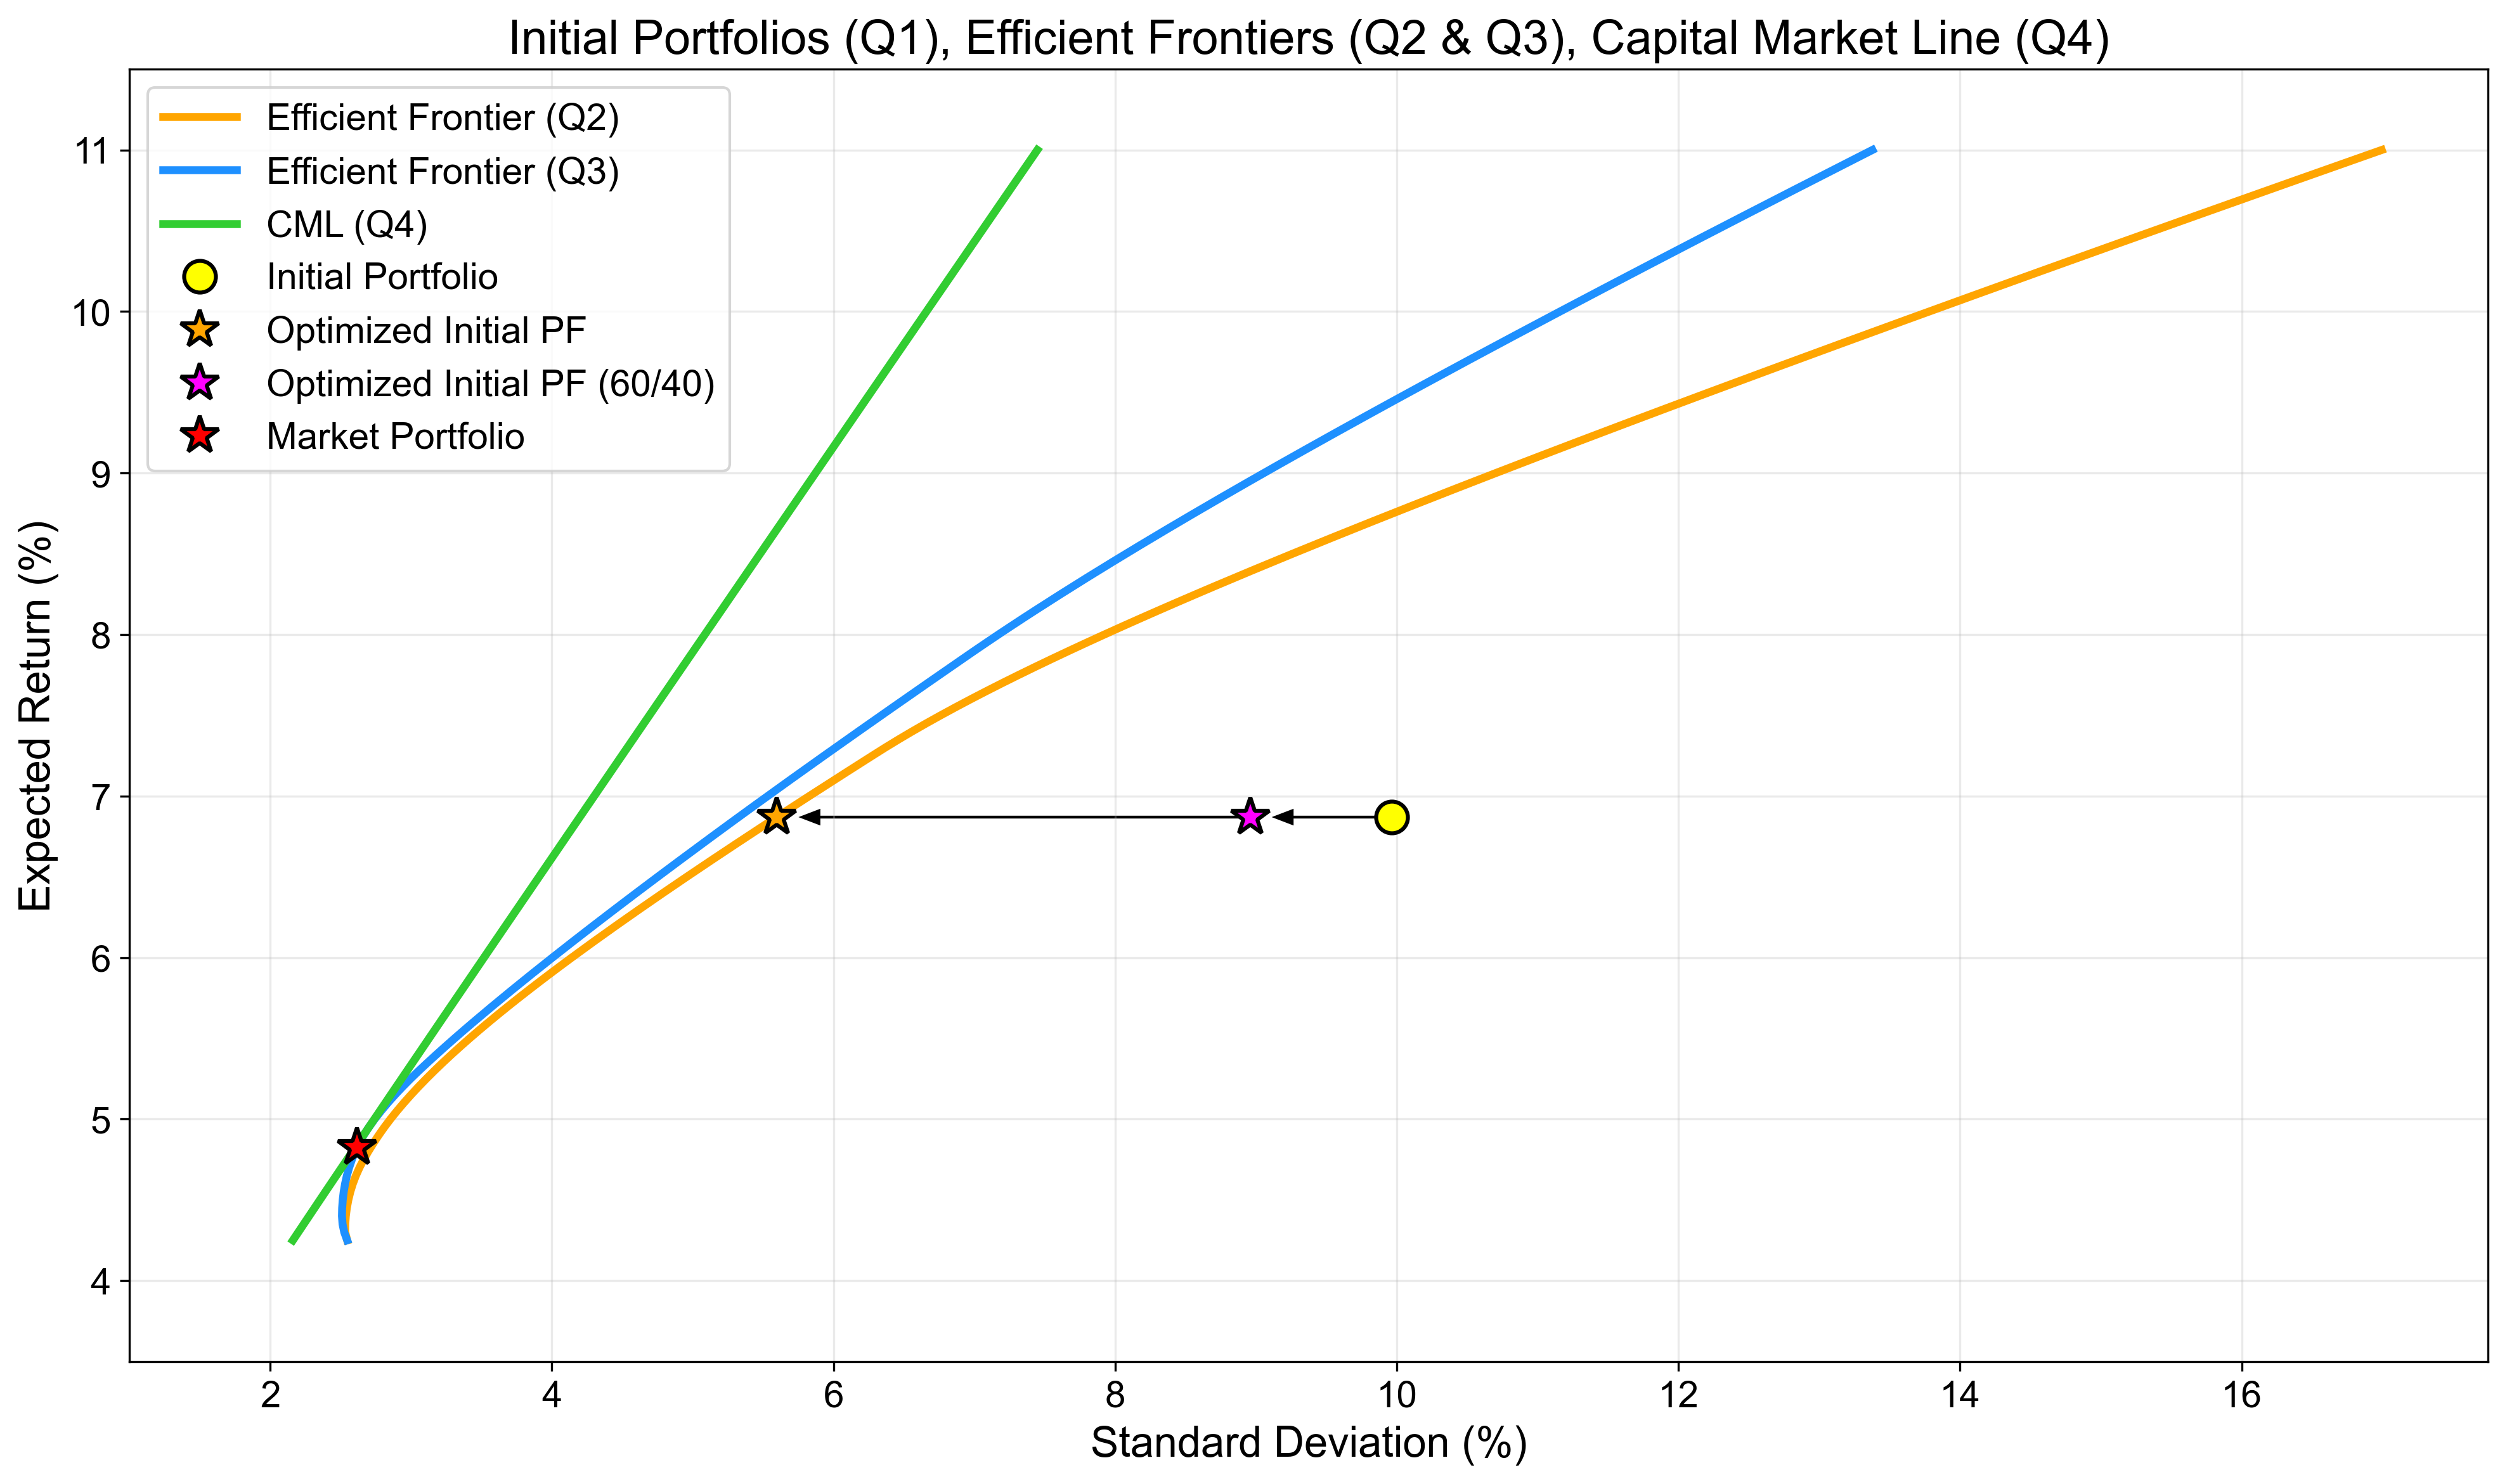

In [10]:
plt.rcParams['font.family'] = 'arial'

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)


# PLOTS: Efficient Frontier (special case), Efficient Frontier (all assets except T-Bills), CML, Simulated Allocations
ax.plot(opt_stdevs_sp, opt_returns_sp, ls='-', linewidth=3, c='orange', label='Efficient Frontier (Q2)')

ax.plot(opt_stdevs_no_short, opt_returns_no_short, ls='-', linewidth=3, c='dodgerblue', label='Efficient Frontier (Q3)')

ax.plot(opt_stdevs_short, opt_returns_short, ls='-', linewidth=3, c='#32cd32', label='CML (Q4)')


# MARKERS: Tangency portfolio, initial portfolio, optimized initial pf, optimized initial pf with split
ax.plot(initial_stdev, initial_return,
        marker='o', mec='k', mew=1.5, mfc='#ff0', markersize=12, linestyle='None', label='Initial Portfolio')

ax.plot(opt_wt_sp_stdev, opt_wt_sp_return,
        marker='*', mec='k', mew=1.5, mfc='orange', markersize=15, linestyle='None', label='Optimized Initial PF')

ax.plot(opt_wt_sp_64_stdev, opt_wt_sp_64_return,
        marker='*', mec='k', mew=1.5, mfc='magenta', markersize=15, linestyle='None', label='Optimized Initial PF (60/40)')

ax.plot(opt_stdev_sharpe, opt_return_sharpe,
        marker='*', mec='k', mew=1.5, mfc='r', markersize=15, linestyle='None', label='Market Portfolio')


# ARROWS
ax.arrow(x=initial_stdev, y=initial_return, dx=(opt_wt_sp_64_stdev - initial_stdev) + 0.3, dy=(opt_wt_sp_64_return - initial_return),
         head_width=0.08, color='k')

ax.arrow(x=opt_wt_sp_64_stdev, y=opt_wt_sp_64_return, dx=(opt_wt_sp_stdev - opt_wt_sp_64_stdev) + 0.3, dy=(opt_wt_sp_return - opt_wt_sp_64_return),
         head_width=0.08, color='k')


ax.set_xlim([1, 17.75])
ax.set_ylim([3.5, 11.5])
ax.set_title('Initial Portfolios (Q1), Efficient Frontiers (Q2 & Q3), Capital Market Line (Q4)', fontsize=18)
ax.set_xlabel('Standard Deviation (%)', fontsize=16)
ax.set_ylabel('Expected Return (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2, fontsize=14)
ax.grid(c='#bbb', alpha=0.3)
plt.show();

Extras: Variable plots for slides. Comment out plots and edit titles as desired depending on slide progression.

In [11]:
# Simulate nine-asset allocations and get their returns and standard deviations
df_ret_9 = df_ret.drop('T_Bill', axis=1)
simulated = simulate(df=df_ret_9, n_iter=3000)
df_sim = pd.DataFrame(data=simulated)

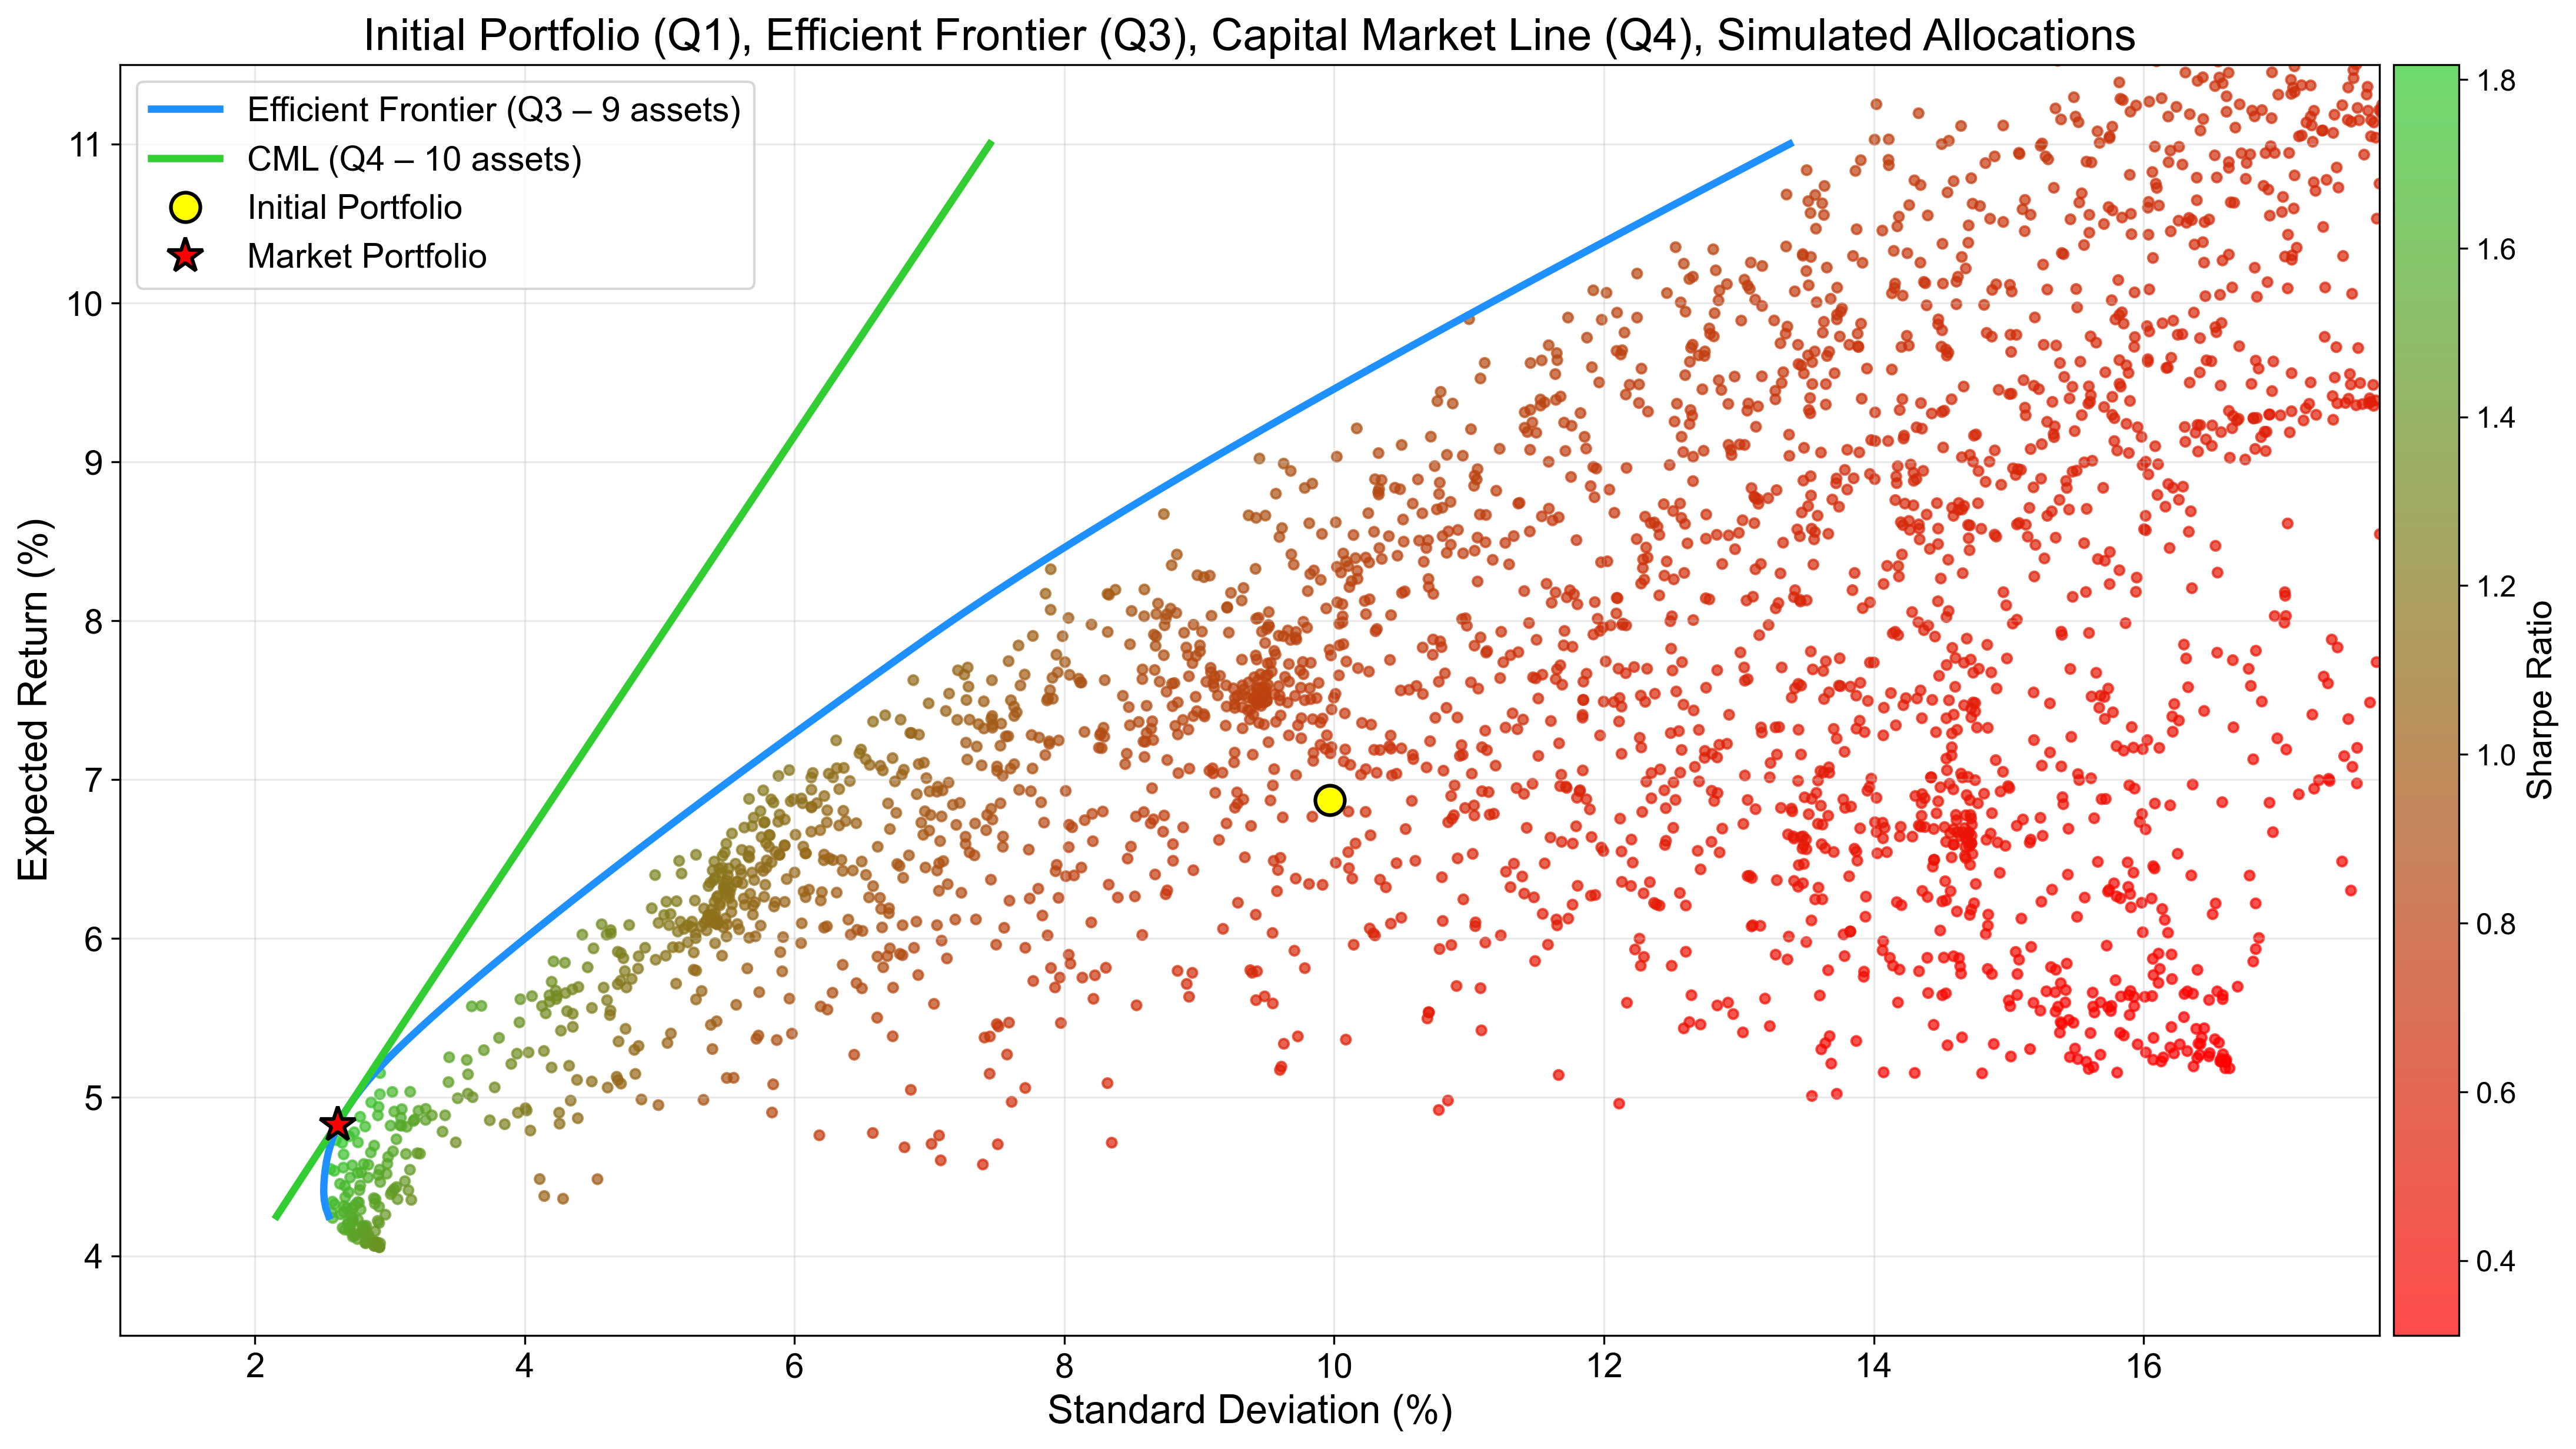

In [12]:
plt.rcParams['font.family'] = 'arial'

# Custom colormap for the simulated allocations' scatterplot
colors = ['#f00', '#32cd32']
cm = LinearSegmentedColormap.from_list('Custom', colors, N=1000)

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)


# PLOTS: Efficient Frontier (special case), Efficient Frontier (all assets except T-Bills), CML, Simulated Allocations
ax.plot(opt_stdevs_no_short, opt_returns_no_short, ls='-', linewidth=3, c='dodgerblue', label='Efficient Frontier (Q3 – 9 assets)')

ax.plot(opt_stdevs_short, opt_returns_short, ls='-', linewidth=3, c='#32cd32', label='CML (Q4 – 10 assets)')

p_sim = ax.scatter(df_sim['portfolio_stdevs'], df_sim['portfolio_returns'],
                   s=15, c=(df_sim['portfolio_returns'] / df_sim['portfolio_stdevs']), cmap=cm, alpha=0.7)
cb_ax = fig.add_axes([0.905, 0.1, 0.023, 0.8])
cbar = plt.colorbar(p_sim, cax=cb_ax) #, pad=0.01, aspect=30)
cbar.set_label(label='Sharpe Ratio', size=14)
cbar.ax.tick_params(labelsize=12)


# MARKERS: Tangency portfolio, initial portfolio, optimized initial pf, optimized initial pf with split
ax.plot(initial_stdev, initial_return,
        marker='o', mec='k', mew=1.5, mfc='#ff0', markersize=12, linestyle='None', label='Initial Portfolio')

ax.plot(opt_stdev_sharpe, opt_return_sharpe,
        marker='*', mec='k', mew=1.5, mfc='r', markersize=15, linestyle='None', label='Market Portfolio')


ax.set_xlim([1, 17.75])
ax.set_ylim([3.5, 11.5])
ax.set_title('Initial Portfolio (Q1), Efficient Frontier (Q3), Capital Market Line (Q4), Simulated Allocations', fontsize=18)
ax.set_xlabel('Standard Deviation (%)', fontsize=16)
ax.set_ylabel('Expected Return (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2, fontsize=14)
ax.grid(c='#bbb', alpha=0.3)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
plt.show();